# Model Optimizer Quadrotor

In [39]:
# packages

%matplotlib notebook
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize, Bounds
import seaborn as sns
import matplotlib.transforms as mtransforms
import matplotlib
import csv
from sklearn.metrics import mean_squared_error

## 1. Build and look at the dataframe

In [53]:
# read the data file
# flight for steps
# filename = "test_data/model_flights/test_flight_06_14_22/model_flight.csv"
# flight for lemniscate
filename = "test_data/model_flights/test_flight_07_07_22/model_flight_lemniscate.csv"
df = pd.read_csv(filename)

# crop and get interested segment
start_log = 0.2
end_log = 0.9
n_samples = len(df.time)

df_crop = df.truncate(int(start_log*n_samples),int(end_log*n_samples))
n_samples_crop = len(df_crop.time)

print(f"New samples: {n_samples_crop}")

New samples: 22469


<IPython.core.display.Javascript object>


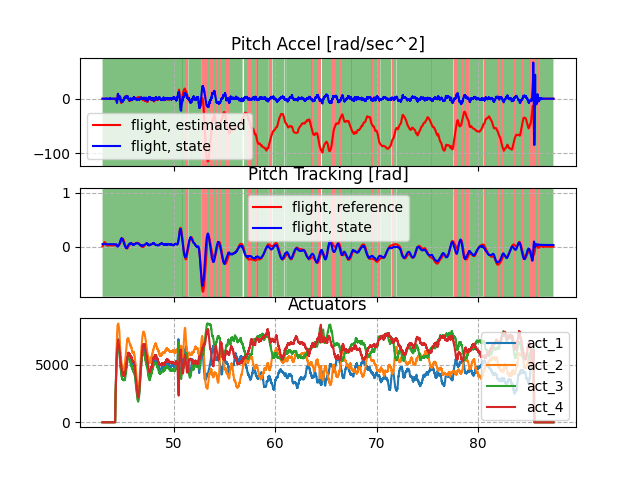

Text(0.5, 1.0, 'Actuators')

In [54]:
# plot them
f, axs = plt.subplots(3, 1, sharex=True)
t_crop = df_crop.time;

# conditional if yaw is not acceptable
threshold = 0.05
err_yaw = abs(df_crop.theta_state - df_crop.theta_ref)

# subplot 1
trans1 = mtransforms.blended_transform_factory(axs[0].transData, axs[0].transAxes)
axs[0].plot(t_crop,df_crop.qd_estimated_f,label="flight, estimated", color="r")
axs[0].plot(t_crop,df_crop.qd_state_f,label="flight, state", color="b")
axs[0].grid(linestyle='--')
axs[0].fill_between(t_crop, 0, 1, where=err_yaw > threshold,
                facecolor='red', alpha=0.5, transform=trans1)
axs[0].fill_between(t_crop, 0, 1, where=err_yaw <= threshold,
                facecolor='green', alpha=0.5, transform=trans1)
axs[0].legend()
axs[0].set_title('Pitch Accel [rad/sec^2]')

# subplot 2
trans2 = mtransforms.blended_transform_factory(axs[1].transData, axs[1].transAxes)
axs[1].plot(t_crop,df_crop.theta_ref,label="flight, reference", color="r")
axs[1].plot(t_crop,df_crop.theta_state,label="flight, state", color="b")
axs[1].fill_between(t_crop, 0, 1, where=err_yaw > threshold,
                facecolor='red', alpha=0.5, transform=trans2)
axs[1].fill_between(t_crop, 0, 1, where=err_yaw <= threshold,
                facecolor='green', alpha=0.5, transform=trans2)
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_title('Pitch Tracking [rad]')

# subplot 3
axs[2].plot(t_crop,df_crop.act_state_1,label="act_1")
axs[2].plot(t_crop,df_crop.act_state_2,label="act_2")
axs[2].plot(t_crop,df_crop.act_state_3,label="act_3")
axs[2].plot(t_crop,df_crop.act_state_4,label="act_4")
axs[2].grid(linestyle='--')
axs[2].legend()
axs[2].set_title('Actuators')

<IPython.core.display.Javascript object>


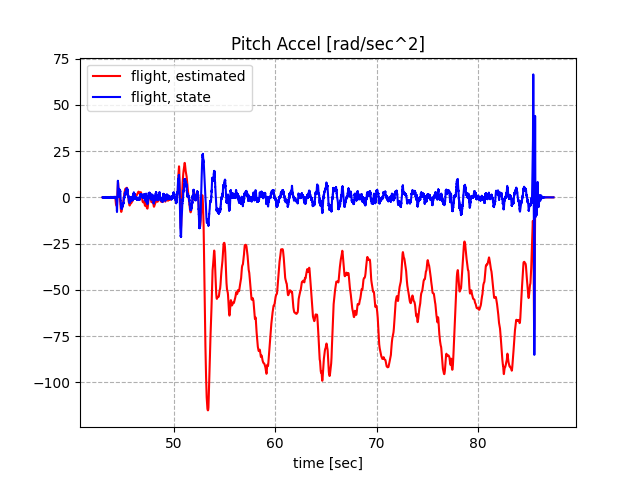

Text(0.5, 1.0, 'Pitch Accel [rad/sec^2]')

In [55]:


# plot them
f, axs = plt.subplots(1, 1, sharex=True)
t_crop = df_crop.time;

# conditional if yaw is not acceptable
threshold = 0.05
err_yaw = abs(df_crop.theta_state - df_crop.theta_ref)

# subplot 1
axs.plot(t_crop,df_crop.qd_estimated_f,label="flight, estimated", color="r")
axs.plot(t_crop,df_crop.qd_state_f,label="flight, state", color="b")
axs.legend()
axs.grid(linestyle='--')
axs.set_xlabel('time [sec]')
axs.set_title('Pitch Accel [rad/sec^2]')

## 2. Explore the Data

We wanna build the model and see if everythin makes sense.

In [56]:
def get_u(Vx, Vy, Vz, phi, theta, psi):
    
    u = np.zeros(len(Vx))
    
    for i in range(len(Vx)):

        # rotation around roll axis
        R_phi = [[1, 0, 0],
                 [0, np.cos(phi[i]), -np.sin(phi[i])],
                 [0, np.sin(phi[i]), np.cos(phi[i])]]

        # rotation around pitch axis
        R_theta = [[np.cos(theta[i]), 0, np.sin(theta[i])],
                   [0, 1, 0],
                   [-np.sin(theta[i]), 0, np.cos(theta[i])]]

        # rotation around yaw axis
        R_psi = [[np.cos(psi[i]), -np.sin(psi[i]), 0],
                 [np.sin(psi[i]), np.cos(psi[i]), 0],
                 [0, 0, 1]]
    
        R_bg = np.linalg.multi_dot([R_psi, R_theta, R_phi])
        
        V_vect = [Vx[i], Vy[i], Vz[i]]
        
        u[i] = np.dot(np.linalg.inv(R_bg),V_vect)[0] 
    
    return u

<IPython.core.display.Javascript object>


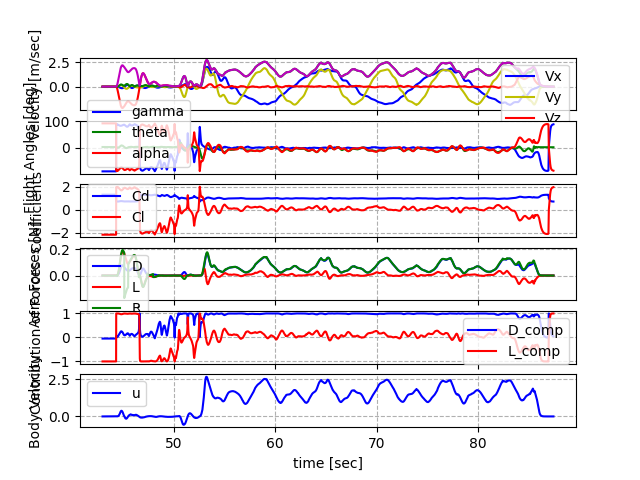

Text(0, 0.5, 'Body Velocity')

In [57]:
# get the input data for the model

# constants
rho = 1.225

# plate 
w_plate = 0.23
h_plate = 0.16
l_plate = 0.12
S_plate = w_plate*h_plate

# aerodynamic coefficients
Cd1 = 0.0033
Cd2 = 0.7
Cl1 = -0.0228
Cl2 = 2.01

# state
Vx = df_crop.xd_state_f.array
Vy = df_crop.yd_state_f.array
Vz = df_crop.zd_state_f.array
phi = df_crop.phi_state.array
theta = df_crop.theta_state.array
psi = df_crop.psi_state.array

# velocity 
Vh = np.sqrt(Vx**2+Vy**2)
Vr = np.sqrt(Vx**2+Vy**2+Vz**2)
u = get_u(Vx, Vy, Vz, phi, theta, psi)

# flight angles
gamma = -np.degrees(np.arctan2(Vz,Vh))
theta = np.degrees(theta)
alpha = theta-gamma

# coefficients
Cd = Cd1*(90+alpha)+Cd2
Cl = Cl1*(90+alpha)+Cl2

# aero forces
D = 0.5*rho*Vr**2*S_plate*Cd
L = 0.5*rho*Vr**2*S_plate*Cl
R = (np.cos(np.radians(alpha))*D - np.sin(np.radians(alpha))*L)*np.sign(u)

# plot the matching
f, axs = plt.subplots(6, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,Vx,label="Vx", color="b")
axs[0].plot(t_crop,Vy,label="Vy", color="y")
axs[0].plot(t_crop,Vz,label="Vz", color="r")
axs[0].plot(t_crop,Vh,label="Vh", color="g")
axs[0].plot(t_crop,Vr,label="Vr", color="m")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_xlabel('time [sec]')
axs[0].set_ylabel('Velocity [m/sec]')

# subplot 2
axs[1].plot(t_crop,gamma,label="gamma", color="b")
axs[1].plot(t_crop,theta,label="theta", color="g")
axs[1].plot(t_crop,alpha,label="alpha", color="r")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_xlabel('time [sec]')
axs[1].set_ylabel('Flight Angles [deg]')

# subplot 3
axs[2].plot(t_crop,Cd,label="Cd", color="b")
axs[2].plot(t_crop,Cl,label="Cl", color="r")
axs[2].grid(linestyle='--')
axs[2].legend()
axs[2].set_xlabel('time [sec]')
axs[2].set_ylabel('Coefficients')

# subplot 4
axs[3].plot(t_crop,D,label="D", color="b")
axs[3].plot(t_crop,L,label="L", color="r")
axs[3].plot(t_crop,R,label="R", color="g")
axs[3].grid(linestyle='--')
axs[3].legend()
axs[3].set_xlabel('time [sec]')
axs[3].set_ylabel('Aero Forces [N]')

# subplot 5
axs[4].plot(t_crop,np.cos(np.radians(theta-gamma)),label="D_comp", color="b")
axs[4].plot(t_crop,-np.sin(np.radians(theta-gamma)),label="L_comp", color="r")
axs[4].grid(linestyle='--')
axs[4].legend()
axs[4].set_xlabel('time [sec]')
axs[4].set_ylabel('Contribution of Forces')

# subplot 6
axs[5].plot(t_crop,u,label="u", color="b")
axs[5].grid(linestyle='--')
axs[5].legend()
axs[5].set_xlabel('time [sec]')
axs[5].set_ylabel('Body Velocity')

Lets see how the estimated model data is going

<IPython.core.display.Javascript object>


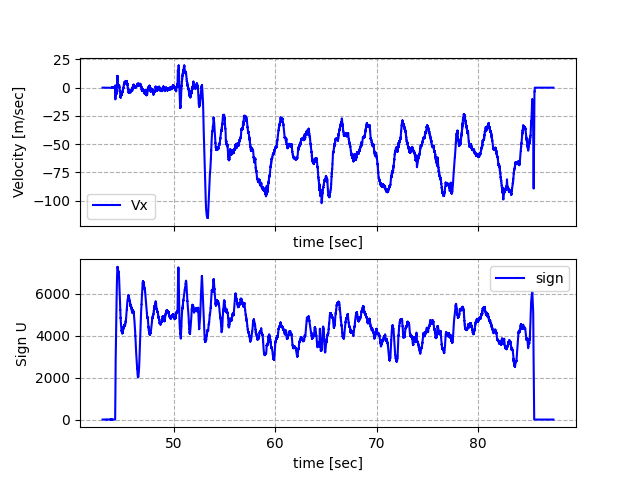

Text(0, 0.5, 'Sign U')

In [59]:
# plot the matching
f, axs = plt.subplots(2, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,df_crop.qd_estimated,label="Vx", color="b")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_xlabel('time [sec]')
axs[0].set_ylabel('Velocity [m/sec]')

# subplot 2
axs[1].plot(t_crop,df_crop.act_state_1,label="sign", color="b")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_xlabel('time [sec]')
axs[1].set_ylabel('Sign U')

## 3. Build the Model Function

We define the model function in terms of an input vector and a set of parameters to be tuned. 

In [60]:
def model_top_plate(x,Cd1,Cd2,Cl1,Cl2):
    
    Vx, Vy, Vz, phi, theta, psi, u = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    
    # constants
    rho = 1.225

    # plate 
    w_plate = 0.23
    h_plate = 0.16
    l_plate = 0.12
    Iyy = 0.0008
    S_plate = w_plate*h_plate
    
    # lift coefficients 
    # Cl1 = -0.0228
    # Cl2 = 2.01

    # velocity 
    Vh = np.sqrt(Vx**2+Vy**2)
    Vr = np.sqrt(Vx**2+Vy**2+Vz**2)
    u = get_u(Vx, Vy, Vz, phi, theta, psi)

    # flight angles
    gamma = -np.degrees(np.arctan2(Vz,Vh))
    theta = np.degrees(theta)
    alpha = theta-gamma

    # coefficients
    Cd = Cd1*(90+alpha)+Cd2
    Cl = Cl1*(90+alpha)+Cl2

    # aero forces
    D = 0.5*rho*Vr**2*S_plate*Cd
    L = 0.5*rho*Vr**2*S_plate*Cl
    R = (np.cos(np.radians(alpha))*D - np.sin(np.radians(alpha))*L)*np.sign(u)
    
    # get the iduced rotational acceleration
    qd_model = -(l_plate*R)/Iyy
    
    return qd_model
  

The input signals are from the state, as well as the signals to be matched.

In [61]:
# input signals required
states = np.zeros((7,n_samples_crop))
states[0] = df_crop.xd_state_f.array
states[1] = df_crop.yd_state_f.array
states[2] = df_crop.zd_state_f.array
states[3] = df_crop.phi_state.array
states[4] = df_crop.theta_state.array
states[5] = df_crop.psi_state.array
states[6] = get_u(states[0],states[1],states[2],states[3],states[4],states[5])

# real signals to match
pitch_accel_est = df_crop.qd_estimated_f.array
pitch_accel_est_model = df_crop.qd_estimated_f.array - df_crop.qd_state_f.array

Let's see if it makes sense the first prediction

<IPython.core.display.Javascript object>


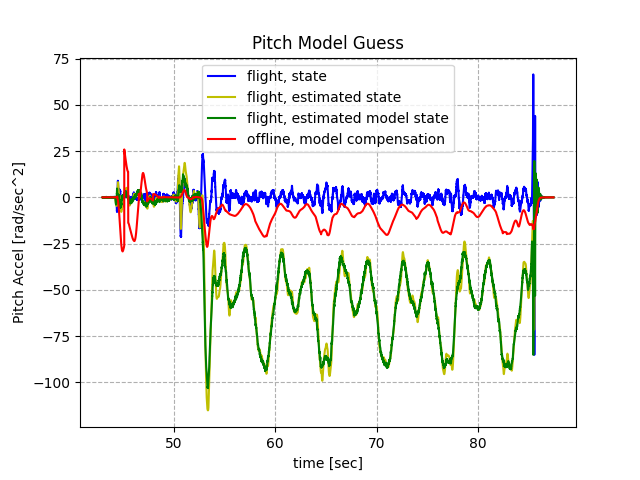

Text(0.5, 1.0, 'Pitch Model Guess')

In [62]:
# initial guess
# this is the first guess
p0_pitch = [0.0033, 0.7, -0.0228, 2.01]
# this is guess opt for step
# p0_pitch = [0.035, 2, -0.000249, 3]
# this is the guess optimized for the lemniscate
# p0_pitch = [3.67969070e-02,  2.00000000e+00, -1.84632826e-15,  1.50000000e+00]

pitch_accel_init = model_top_plate(states,p0_pitch[0],p0_pitch[1],p0_pitch[2],p0_pitch[3])

# plot the matching
f, axs = plt.subplots(1, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs.plot(t_crop,df_crop.qd_state_f,label="flight, state", color="b")
axs.plot(t_crop,pitch_accel_est,label="flight, estimated state", color="y")
axs.plot(t_crop,pitch_accel_est_model,label="flight, estimated model state", color="g")
axs.plot(t_crop,pitch_accel_init,label="offline, model compensation", color="r")
axs.grid(linestyle='--')
axs.legend()
axs.set_xlabel('time [sec]')
axs.set_ylabel('Pitch Accel [rad/sec^2]')
axs.set_title('Pitch Model Guess')

The model gives a curve that should fit the estimated yaw acceleration. Lets plot it and see

In [63]:
# bounds [Cd1, Cd2, Cl1, Cl2]
ub = [5, 2, 0, 3]
lb = [0, 0.6, -5, 1.5]

optimize =  0;

if optimize:

    popt_pitch, pcov_pitch = curve_fit(model_top_plate, states, pitch_accel_est_model, bounds = (lb, ub), p0=p0_pitch)
    
print(popt_pitch)
print(pcov_pitch)

[ 3.52881576e-02  2.00000000e+00 -2.49641730e-03  3.00000000e+00]
[[ 3.84761798e-05 -3.49894605e-03 -3.24782456e-06  2.25893903e-03]
 [-3.49894605e-03  3.18287190e-01  2.95412499e-04 -2.05196109e-01]
 [-3.24782456e-06  2.95412499e-04  1.85130485e-06 -3.66971696e-04]
 [ 2.25893903e-03 -2.05196109e-01 -3.66971696e-04  1.53644155e-01]]


<IPython.core.display.Javascript object>


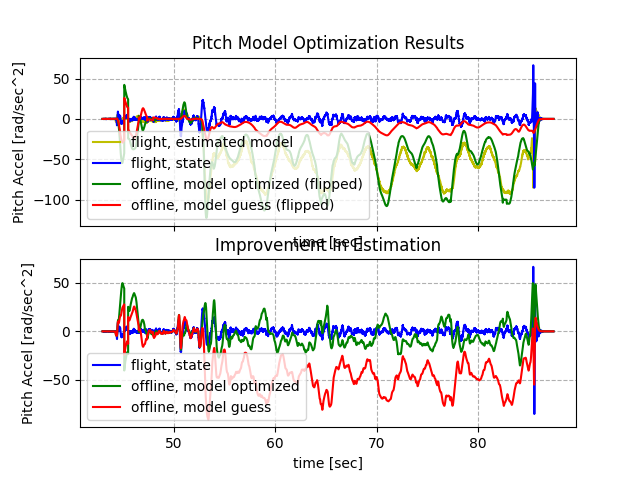

Text(0.5, 1.0, 'Improvement In Estimation')

In [64]:
# previous, stored result
use_last = 0

# this is the last for the step maneouver
p0_last = [0.035, 2, -0.000249, 3]

# this is the last optimization result for the lemniscate
# p0_last = [ 3.67969070e-02,  2.00000000e+00, -1.84632826e-15,  1.50000000e+00]

# data for state
pitch_accel_flight = df_crop.qd_state_f.array
pitch_accel_model_init = df_crop.qd_estimated_f.array
if use_last:
    pitch_accel_model_opt = model_top_plate(states,p0_last[0],p0_last[1],p0_last[2],p0_last[3])
else:
    pitch_accel_model_opt = model_top_plate(states,popt_pitch[0],popt_pitch[1],popt_pitch[2],popt_pitch[3])
    
# lets see if we match the state now
pitch_accel_comp = pitch_accel_est - pitch_accel_model_opt

# plot the matching
f, axs = plt.subplots(2, 1, sharex=True)
t_crop = df_crop.time;

# subplot 1
axs[0].plot(t_crop,pitch_accel_est_model,label="flight, estimated model", color="y")
axs[0].plot(t_crop,pitch_accel_flight,label="flight, state", color="b")
axs[0].plot(t_crop,pitch_accel_model_opt,label="offline, model optimized (flipped)", color="g")
axs[0].plot(t_crop,pitch_accel_init,label="offline, model guess (flipped)", color="r")
axs[0].grid(linestyle='--')
axs[0].legend()
axs[0].set_xlabel('time [sec]')
axs[0].set_ylabel('Pitch Accel [rad/sec^2]')
axs[0].set_title('Pitch Model Optimization Results')

# subplot 2
axs[1].plot(t_crop,pitch_accel_flight,label="flight, state", color="b")
axs[1].plot(t_crop,pitch_accel_est - pitch_accel_model_opt,label="offline, model optimized", color="g")
axs[1].plot(t_crop,pitch_accel_est - pitch_accel_init,label="offline, model guess", color="r")
axs[1].grid(linestyle='--')
axs[1].legend()
axs[1].set_xlabel('time [sec]')
axs[1].set_ylabel('Pitch Accel [rad/sec^2]')
axs[1].set_title('Improvement In Estimation')

In [65]:
# log data to csv file for better plotting

header = ['time','state_f','state_estimated','drag_effect','state_model_guess','state_model_optimized']
with open('model_data.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for i in range(len(t_crop)):
        row = [t_crop.array[i],
               df_crop.qd_state_f.array[i],
               pitch_accel_est[i],
               pitch_accel_est_model[i],
               pitch_accel_init[i],
               pitch_accel_model_opt[i]]
        writer.writerow(row)

In [66]:
# get mse for fit error

mse_guess = mean_squared_error(pitch_accel_est_model, pitch_accel_init)
mse_opt = mean_squared_error(pitch_accel_est_model, pitch_accel_model_opt)

print(f"mse_guess = {mse_guess}")
print(f"mse_opt = {mse_opt}")
print(f"factor = {mse_guess/mse_opt}")

mse_guess = 1850.6192080423184
mse_opt = 173.17910875814243
factor = 10.686157362241923
